In [13]:
import pickle
import random
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse, rmse_network
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Simulation parameters
RUNS = 100
FILEPATH_CSV = "./simulations/expf/rmse_cam.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 100
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
# q = 10
# r = 1.3
NDIM = 2
TRAJ_MODEL = CAModel(q, r, ndim=NDIM)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 5
expf = 0.95  # Exponential forgetting param

m = "cam"

In [16]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

# plot_traj(traj)

In [17]:
# No coop nodes
rmse_data = np.zeros((ndat, 4 * NDIM))

# Save state estimates of a random run
random_n = random.randint(0, RUNS - 1)

# Run simulations
for i in range(RUNS):
    ###
    kfs = [
        KalmanFilter(CAModel(q, r, ndim=NDIM), lambda_expf=1.0),
        KalmanFilter(CAModel(q, r, ndim=NDIM), lambda_expf=0.995),
        KalmanFilter(CAModel(q, r, ndim=NDIM), lambda_expf=0.975),
        KalmanFilter(CAModel(q, r, ndim=NDIM), lambda_expf=0.95),
    ]

    # Add observation noise for each node
    traj.simulate(ndat, INIT_STATE)
    traj.add_obs_noise(R=False)

    # Run estimation
    for yt in traj.observations:
        for kf in kfs:
            kf.predict()
            kf.update(yt, log=True)

    # Save results
    rmse_data += rmse_network([], traj, ndat, 2, *kfs)

    if random_n == i:
        # Save state estimates of a random run
        dfs = []
        for kf in kfs:
            dfs.append(kf.to_dataframe(traj))

        fp = "./simulations/expf/"
        for df, kf in zip(dfs, kfs):
            n = m + "_" + str(kf.lambda_expf) + ".csv"
#             df.to_csv(fp + n, index_label="t")

In [18]:
# Average the results
rmse_data /= RUNS

In [19]:
# CSV column labels
cols = []
for n in ["100", "995", "975", "950"]:
    for x in ("x1", "x2"):
        cols.append(x + "_" + n)

# Generate CSV files
df = pd.DataFrame(data=rmse_data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,x1_100,x2_100,x1_995,x2_995,x1_975,x2_975,x1_950,x2_950
0,1.122323,1.044899,1.122328,1.044903,1.122344,1.044919,1.122366,1.044939
1,1.217450,1.230556,1.217458,1.230564,1.217487,1.230596,1.217524,1.230636
2,1.194460,1.260520,1.194482,1.260555,1.194568,1.260694,1.194674,1.260862
3,1.208869,1.229660,1.208974,1.229748,1.209399,1.230102,1.209935,1.230554
4,1.202747,1.257423,1.202882,1.257482,1.203442,1.257739,1.204189,1.258096


In [20]:
x1_cols = [col for col in df.columns if "x1" in col]
x2_cols = [col for col in df.columns if "x2" in col]

<AxesSubplot:xlabel='t', ylabel='logRMSE'>

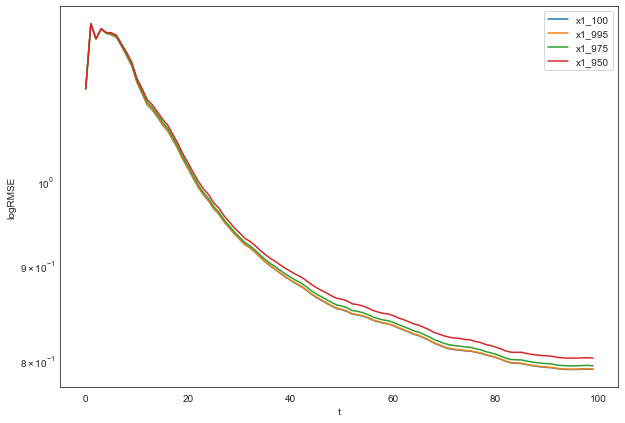

In [21]:
df[x1_cols].plot(figsize=(10, 7), logy=True, ylabel="logRMSE", xlabel="t")

<AxesSubplot:xlabel='t', ylabel='logRMSE'>

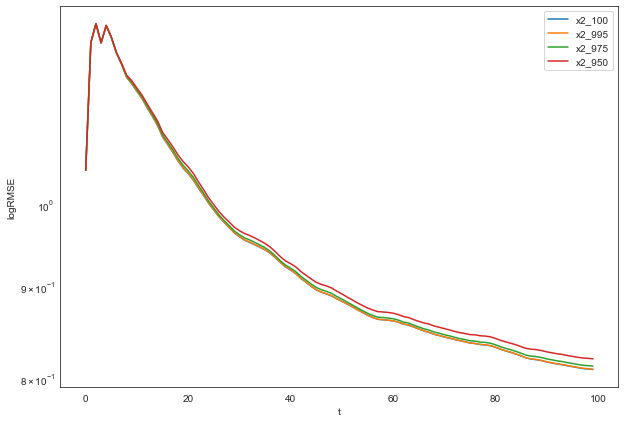

In [22]:
df[x2_cols].plot(figsize=(10, 7), logy=True, ylabel="logRMSE", xlabel="t")

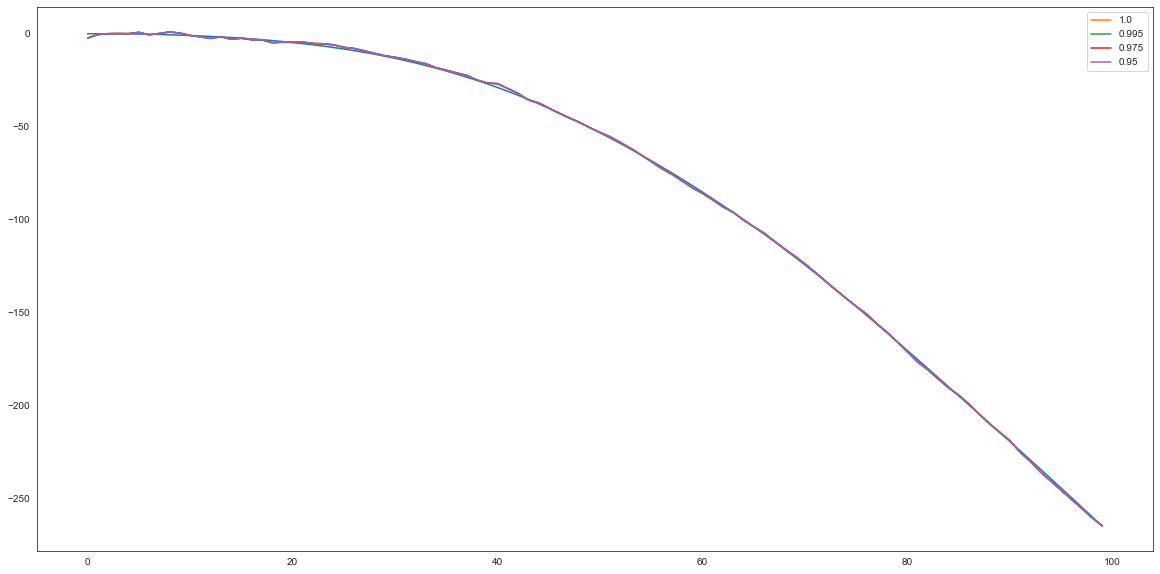

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(traj.states[:, 0])
for kf in kfs:
    plt.plot(kf.history[:, 0], "-", label=str(kf.lambda_expf))

plt.legend()
plt.show()

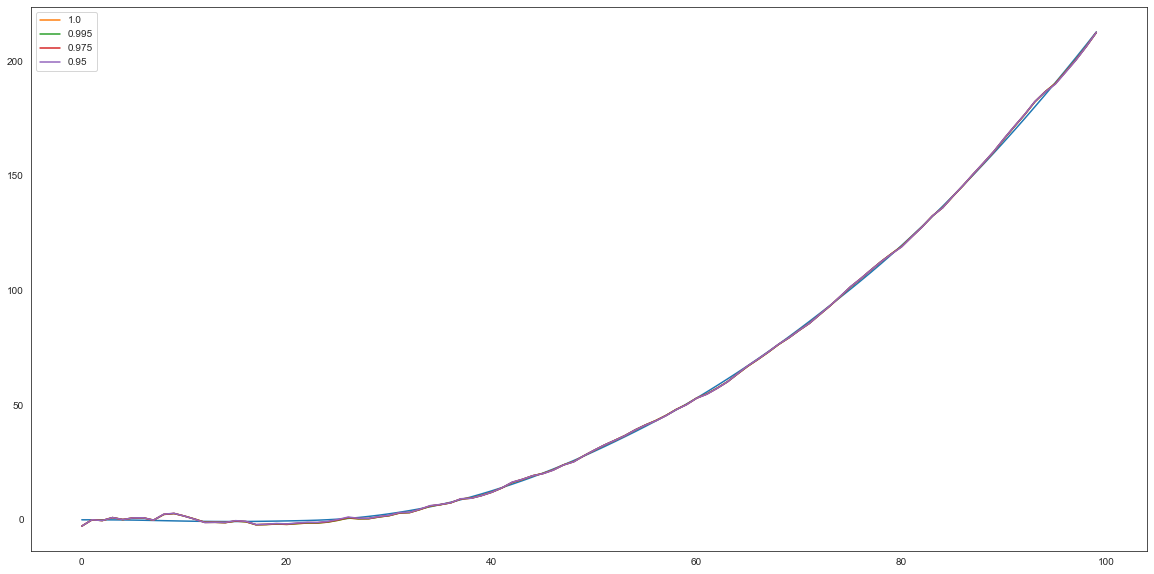

In [24]:
plt.figure(figsize=(20, 10))
plt.plot(traj.states[:, 1])
for kf in kfs:
    plt.plot(kf.history[:, 1], "-", label=str(kf.lambda_expf))

plt.legend()
plt.show()